# Models

Build models to see how much each feature contributes to productivity

- Models
    - LinearRegression
    - ExplainableBoostingRegressor
- Features
    - Education
    - Population
    - R&D Expenditure
    
## Feature Engineering

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [148]:
# See: ../src/data/make_dataset.py
df = pd.read_csv('../data/interim/dataset.csv')
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,hrst,tax_rate,imports,trade
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,49.500000,35.486154,74.1,615059.8
1,2011,Belgium,Euro,Compensation of employees per hour worked,35.1,NaN,47.857143,11000638,2.17,1.81431,49.800000,35.564615,80.8,683436.4
2,2012,Belgium,Euro,Compensation of employees per hour worked,36.2,NaN,48.242857,11075889,2.28,1.79743,50.500000,35.439231,80.3,694177.2
3,2013,Belgium,Euro,Compensation of employees per hour worked,37.2,NaN,49.242857,11137974,2.33,1.75557,49.800000,34.957692,78.5,705911.4
4,2014,Belgium,Euro,Compensation of employees per hour worked,37.6,NaN,50.285714,11180840,2.37,1.74223,51.266667,34.870769,79.0,710575.4


## Add Trends

There are several ways to capture trends.

- Move data to n years (`shift`)
- Take the mean of n years
- ...

In [149]:
features = ['education', 'population', 'rd_expenditure', 'fertility_rate', 'hrst', 'tax_rate', 'imports', 'trade']
shift_range = [1, 2]

def add_trends(df):
    for feature in features:
        for shift in shift_range:
            df[f'{feature}_shift_{shift}'] = df.sort_values('year').groupby(['GEO'])[feature].shift(shift)
            df[f'{feature}_diff_{shift}'] = df[feature] - df[f'{feature}_shift_{shift}']

add_trends(df)
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,tax_rate_shift_2,tax_rate_diff_2,imports_shift_1,imports_diff_1,imports_shift_2,imports_diff_2,trade_shift_1,trade_diff_1,trade_shift_2,trade_diff_2
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,Belgium,Euro,Compensation of employees per hour worked,35.1,NaN,47.857143,11000638,2.17,1.81431,...,NaN,NaN,74.1,6.7,NaN,NaN,615059.8,68376.6,NaN,NaN
2,2012,Belgium,Euro,Compensation of employees per hour worked,36.2,NaN,48.242857,11075889,2.28,1.79743,...,35.486154,-0.046923,80.8,-0.5,74.1,6.2,683436.4,10740.8,615059.8,79117.4
3,2013,Belgium,Euro,Compensation of employees per hour worked,37.2,NaN,49.242857,11137974,2.33,1.75557,...,35.564615,-0.606923,80.3,-1.8,80.8,-2.3,694177.2,11734.2,683436.4,22475.0
4,2014,Belgium,Euro,Compensation of employees per hour worked,37.6,NaN,50.285714,11180840,2.37,1.74223,...,35.439231,-0.568462,78.5,0.5,80.3,-1.3,705911.4,4664.0,694177.2,16398.2


## Add Aggregation Features

In [150]:
# agg_params = {}
# for feature in features:
#     for shift in shift_range:
#         agg_params[f'{feature}_shift_{shift}_mean'] = (f'{feature}_shift_{shift}', 'mean')

# agg = df.groupby('year').agg(**agg_params).reset_index()
# df = df.merge(agg, on='year')
# df.head()

In [151]:
# for feature in features:
#     for shift in shift_range:
#         df[f'{feature}_shift_{shift}_mean_diff'] = df[f'{feature}_shift_{shift}'] - df[f'{feature}_shift_{shift}_mean']
# df.head()

## Scale Features

In [152]:
shift_1_features = [
    'education_shift_1',
    'population_shift_1',
    'rd_expenditure_shift_1',
    'fertility_rate_shift_1',
    'hrst_shift_1',
    'tax_rate_shift_1',
    'imports_shift_1',
    'trade_shift_1',
]

shift_2_features = [
    'education_shift_2',
    'population_shift_2',
    'rd_expenditure_shift_2',
    'fertility_rate_shift_2',
    'hrst_shift_2',
    'tax_rate_shift_2',
    'imports_shift_2',
    'trade_shift_1'
]

all_features = shift_1_features + shift_2_features

def scale(df):
    for column in all_features:
        scaler = MinMaxScaler()
        df[column] = scaler.fit_transform(df[[column]])

scale(df)
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,tax_rate_shift_2,tax_rate_diff_2,imports_shift_1,imports_diff_1,imports_shift_2,imports_diff_2,trade_shift_1,trade_diff_1,trade_shift_2,trade_diff_2
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,Belgium,Euro,Compensation of employees per hour worked,35.1,NaN,47.857143,11000638,2.17,1.81431,...,NaN,NaN,0.298387,6.7,NaN,NaN,0.237825,68376.6,NaN,NaN
2,2012,Belgium,Euro,Compensation of employees per hour worked,36.2,NaN,48.242857,11075889,2.28,1.79743,...,0.996924,-0.046923,0.339950,-0.5,0.298387,6.2,0.264567,10740.8,615059.8,79117.4
3,2013,Belgium,Euro,Compensation of employees per hour worked,37.2,NaN,49.242857,11137974,2.33,1.75557,...,1.000000,-0.606923,0.336849,-1.8,0.339950,-2.3,0.268768,11734.2,683436.4,22475.0
4,2014,Belgium,Euro,Compensation of employees per hour worked,37.6,NaN,50.285714,11180840,2.37,1.74223,...,0.995085,-0.568462,0.325682,0.5,0.336849,-1.3,0.273357,4664.0,694177.2,16398.2


## Split Dataset

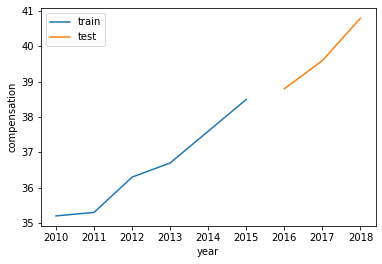

train shape: (180, 46), test shape: (90, 46)


In [153]:
train_size = 0.7

years = df['year'].unique()
years = sorted(years)
pivot = int(len(years) * train_size)
train_index = years[:pivot]
test_index = years[pivot:]

train_df = df[df['year'].isin(train_index)]
test_df = df[df['year'].isin(test_index)]

train_temp = train_df[train_df['GEO'] == 'Denmark']
test_temp = test_df[test_df['GEO'] == 'Denmark']
sns.lineplot(data=train_temp, x='year', y='compensation', label='train')
sns.lineplot(data=test_temp, x='year', y='compensation', label='test')
plt.show()

print(f'train shape: {train_df.shape}, test shape: {test_df.shape}')

In [154]:
# train_df = pd.read_csv('../data/interim/train.csv')
# test_df = pd.read_csv('../data/interim/test.csv')
# train_df.head()

## Visualization for Train Dataset

- Correlation
- jointplot
- pairplot

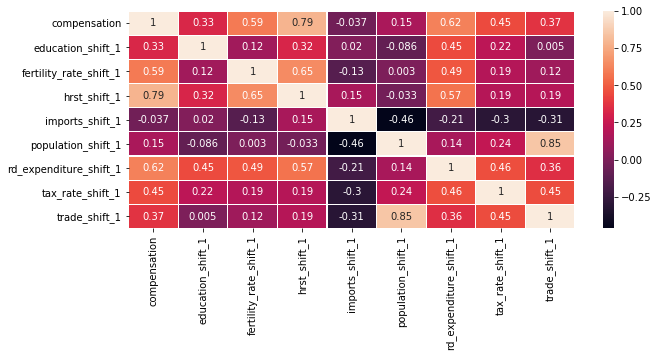

In [156]:
features = [
    sorted(shift_1_features)
]

for fs in features:
    corr = train_df[
        ['compensation'] + fs
    ].corr()
    plt.figure(figsize=(10,4))
    sns.heatmap(corr, annot=True, linewidths=0.2)
    plt.show()

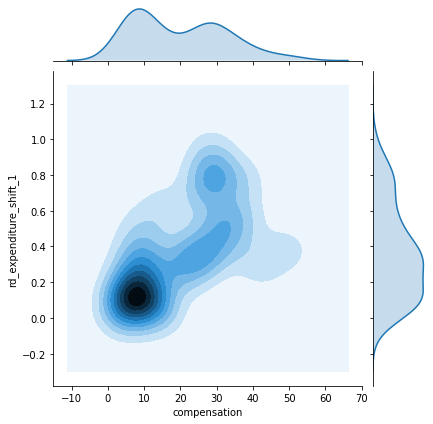

In [132]:
sns.jointplot(data=train_df, x='compensation', y='rd_expenditure_shift_1', kind='kde')

# Train Models

Train models to predict compensation (productivity) using past data.

## LinearRegression

$$
y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$

,features,error,train or test
3,"education_shift_2, population_shift_2, rd_expe...",6.317668,test
0,"education_shift_1, population_shift_1, rd_expe...",6.329397,train
2,"education_shift_2, population_shift_2, rd_expe...",6.434285,train
1,"education_shift_1, population_shift_1, rd_expe...",6.572377,test


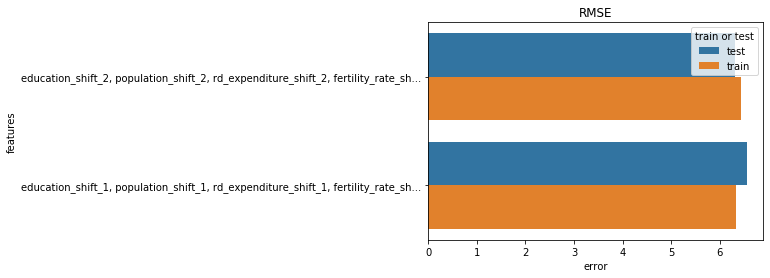

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit(features):
    train_temp = train_df[features + ['compensation']].dropna()
    test_temp = test_df[features + ['compensation']].dropna()
    x_train, y_train = train_temp[features], train_temp[['compensation']]
    x_test, y_test = test_temp[features], test_temp[['compensation']]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    train_error = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
    test_error = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    return train_error, test_error

features = [
    shift_1_features,
    shift_2_features,
]

rows = []
for fs in features:
    train_error, test_error = fit(fs)
    feature_name = ', '.join(fs)
    if len(feature_name) > 80:
        feature_name = feature_name[:80] + '...'
    rows.append({
        'features': feature_name,
        'error': train_error,
        'train or test': 'train'
    })
    rows.append({
        'features': feature_name,
        'error': test_error,
        'train or test': 'test'
    })
    
result = pd.DataFrame(rows).sort_values(by='error')
display(result)

sns.barplot(data=result, x='error', y='features', hue='train or test').set_title('RMSE')
plt.show()

In [134]:
train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## LightGBM

This is a kind of gradient boosting tree.

GitHub: https://github.com/microsoft/LightGBM

In [135]:
import shap
shap.initjs()

In [136]:
from lightgbm import LGBMRegressor

train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

gbm = LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Tune LightGBM using Optuna

Optuna employs a Bayesian optimization algorithm called Tree-structured Parzen Estimator.

Paper: https://arxiv.org/abs/1907.10902
GitHub: https://github.com/optuna/optuna

In [137]:
import lightgbm as lgb
import optuna

def objective(trial):
    param = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": 0,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
    }

    dtrain = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(param, dtrain)
    error = np.sqrt(mean_squared_error(y_test, gbm.predict(x_test)))
    return error

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 3.1491070984210925
  Params: 
 lambda_l1: 2.375783083629217e-05
 lambda_l2: 0.0009528857453928667
 num_leaves: 142
 feature_fraction: 0.6445604007132973
 bagging_fraction: 0.9284070728232413
 bagging_freq: 5
 min_child_samples: 8


In [138]:
dtrain = lgb.Dataset(x_train, label=y_train)
params = trial.params
params['objective'] = 'regression'
tuned_gbm = lgb.train(params, dtrain)
error = np.sqrt(mean_squared_error(y_test, tuned_gbm.predict(x_test)))
error

3.1491070984210925

,model,error
0,LinearRegression,6.572377
1,LightGBM,4.209277
2,Tuned LightGBM,3.149107


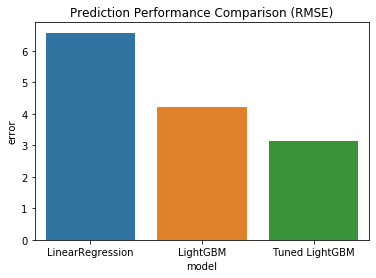

In [139]:
rows = []
rows.append({
    'model': 'LinearRegression',
    'error': np.sqrt(mean_squared_error(y_test, lr.predict(x_test))),
})
rows.append({
    'model': 'LightGBM',
    'error': np.sqrt(mean_squared_error(y_test, gbm.predict(x_test))),
})
rows.append({
    'model': 'Tuned LightGBM',
    'error': np.sqrt(mean_squared_error(y_test, tuned_gbm.predict(x_test))),
})
result = pd.DataFrame(rows).sort_values('error', ascending=False)
display(result)
sns.barplot(data=result, x='model', y='error').set_title('Prediction Performance Comparison (RMSE)')
plt.show()

# Visualize Predictions

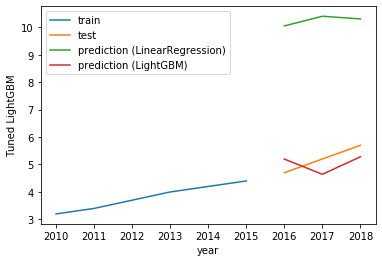

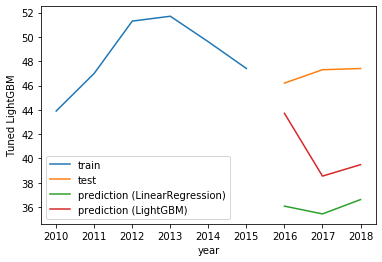

In [140]:
def visualize_prediction(country):
    train_temp = train_df[train_df['GEO'] == country]
    test_temp = test_df[shift_1_features + ['compensation', 'year', 'GEO']].dropna()
    test_temp = test_temp[test_temp['GEO'] == country]
    x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

    test_temp['LinearRegression'] = lr.predict(x_test)
    test_temp['Tuned LightGBM'] = tuned_gbm.predict(x_test)

    sns.lineplot(data=train_temp, x='year', y='compensation', label='train')
    sns.lineplot(data=test_temp, x='year', y='compensation', label='test')
    sns.lineplot(data=test_temp, x='year', y='LinearRegression', label='prediction (LinearRegression)')
    sns.lineplot(data=test_temp, x='year', y='Tuned LightGBM', label='prediction (LightGBM)')
    plt.show()

for country in ['Bulgaria', 'Norway']:
    visualize_prediction(country)

# Visualize Feature Importance

- Coefficients (LinearRegression)
- Feature Importances (Booster)
- Shap (LightBGM)
  - Paper: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
  - GitHub: https://github.com/slundberg/shap
- InterpretML (ExplainableBoostingRegressor)
  - GitHub: https://github.com/interpretml/interpret

,feature,coef
4,hrst_shift_1,35.422279
5,tax_rate_shift_1,14.986013
3,fertility_rate_shift_1,5.834073
7,trade_shift_1,4.624766
1,population_shift_1,3.002697
2,rd_expenditure_shift_1,2.498600
0,education_shift_1,2.354182
6,imports_shift_1,1.102897


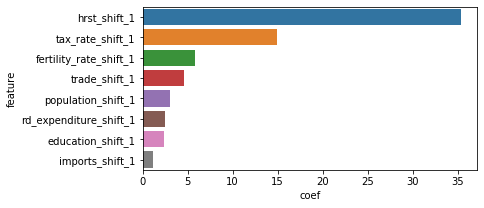

In [141]:
train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

lr = LinearRegression()
lr.fit(x_train, y_train)

result = pd.DataFrame({
    'feature': shift_1_features,
    'coef': lr.coef_[0]
}).sort_values(by=['coef'], ascending=False)
display(result)

plt.figure(figsize=(6, 3))
sns.barplot(data=result, y='feature', x='coef')

,Value,Feature
7,82,population_shift_1
6,74,trade_shift_1
5,69,rd_expenditure_shift_1
4,68,hrst_shift_1
3,64,imports_shift_1
2,52,tax_rate_shift_1
1,44,fertility_rate_shift_1
0,37,education_shift_1


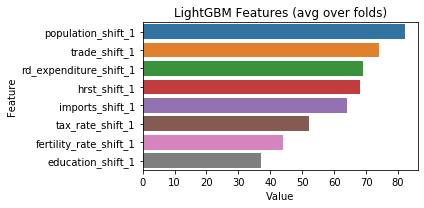

In [142]:
feature_importances = pd.DataFrame(sorted(zip(gbm.feature_importances_, shift_1_features)), columns=['Value','Feature'])
result = feature_importances.sort_values(by="Value", ascending=False)
display(result)

plt.figure(figsize=(6, 3))
sns.barplot(x="Value", y="Feature", data=result)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [143]:
explainer = shap.TreeExplainer(tuned_gbm)
shap_values = explainer.shap_values(x_test)

shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

/usr/local/lib/python3.7/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



In [159]:
sorted(np.abs(shap_values).mean(0))[::-1]

[5.644548762682192,
 2.203230765423675,
 1.9676327064847685,
 1.8353589718807652,
 1.2188464969971398,
 1.1415957921945799,
 0.905852356142835,
 0.8525199798158778]

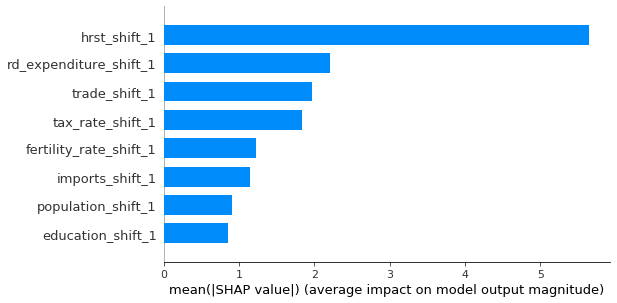

In [145]:
shap.summary_plot(shap_values, x_test, plot_type='bar')

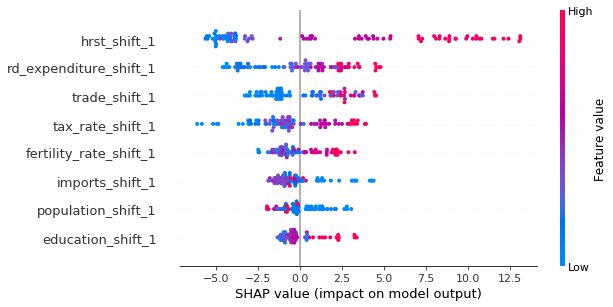

In [144]:
shap.summary_plot(shap_values, x_test)

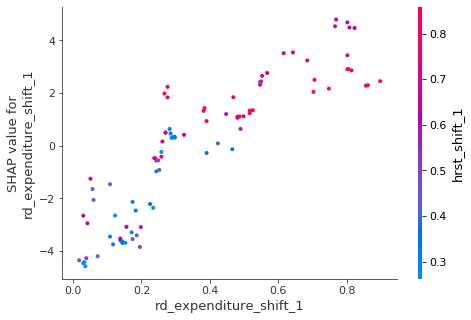

In [146]:
shap.dependence_plot('rd_expenditure_shift_1', shap_values, x_test)

## ExplainableBoostingRegressor (from InterpretML)

EBM is a generalized additive model formalized as follows.

$$
g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ij}(x_i,x_j)
$$

EBM learns the best feature function $f_j$ for each feature to show how each feature contributes to the model's prediction for the problem. EBM can also automatically detect and include pairwise interaction terms.

Paper: https://arxiv.org/pdf/1909.09223.pdf

### Global Explanation

In [25]:
from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingRegressor

train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(x_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
interpret.show(ebm_global)

<!-- http://127.0.0.1:7784/4860241680/ -->

### Local Explanation

In [26]:
ebm_local = ebm.explain_local(x_test[:5], y_test[:5], name='EBM')
interpret.show(ebm_local)

<!-- http://127.0.0.1:7784/4595929488/ -->

In [27]:
from interpret.glassbox import LinearRegression
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(x_test, y_test, name='Linear Regression')
interpret.show(ebm_perf)

<!-- http://127.0.0.1:7784/5154541712/ -->